In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import display
from IPython.display import display_html 
import sys
import os
import jax
import numpyro
numpyro.set_platform('cpu')
print(jax.lib.xla_bridge.get_backend().platform)
import jax.numpy as jnp

cpu


In [2]:
# paths
os.chdir("/Users/")
sys.path.append("functions")

data_save_path = './data/stock_market_data/'

# load models and functions
import models
import my_utils

cpu
Is 64 precision enabled?: True
cpu
Is 64 precision enabled?: True


In [3]:
stock_vals = pd.read_csv(data_save_path + 'stock_trans.csv', index_col='Unnamed: 0').values
E_clean = jnp.array(jnp.load(data_save_path + 'E_pears_clean.npy'))
P_clean = jnp.array(jnp.load(data_save_path + 'P_pears_clean.npy'))
net_no = 2

n,p = stock_vals.shape

# Compile results

In [4]:
# 1MCMC
output_dict_glasso = { "eta1_0":[],"Pos":[], "Neg":[]}

output_dict_ss_E_P = {"eta0_0":[],"eta0_coefs":[], "eta1_0":[],"eta1_coefs":[], "eta2_0":[],"eta2_coefs":[],
                    "w_slab":[], "mean_slab":[], "scale_slab":[],"Pos":[], "Neg":[], "Pos_95":[], "Neg_95":[],}


outputs = {"GLASSO":output_dict_glasso, 
           "NetworkSS_E_P":output_dict_ss_E_P }

with open(data_save_path + f'glasso_mcmc.sav', 'rb') as fr:
    res_glasso = pickle.load(fr)
        
with open(data_save_path + f'NetworkSS_E_P_1mcmc.sav', 'rb') as fr:
    res_ss_E_P = pickle.load(fr)
    

all_res = {"GLASSO":res_glasso, "NetworkSS_E_P":res_ss_E_P}

for i, res in all_res.items():
    print(i)


    outputs[i]["eta1_0"].append(res['all_samples']["eta1_0"].mean(0))

    try:
        outputs[i]["eta0_0"].append(res['all_samples']["eta0_0"].mean(0))
        outputs[i]["eta2_0"].append(res['all_samples']["eta2_0"].mean(0))
        outputs[i]["w_slab"].append(res['all_samples']["w_slab"].mean(0))
        outputs[i]["mean_slab"].append(res['all_samples']["mean_slab"].mean(0))
        outputs[i]["scale_slab"].append(res['all_samples']["scale_slab"].mean(0))

    except:
        pass

    try:
        outputs[i]["eta1_coefs"].append(res['all_samples']["eta1_coefs"].mean(0))
    except:
        pass

    try:   
        outputs[i]["eta0_coefs"].append(res['all_samples']["eta0_coefs"].mean(0))
        outputs[i]["eta2_coefs"].append(res['all_samples']["eta2_coefs"].mean(0))
    except:
        pass

    if 'eta0_0' not in outputs[i].keys():

        outputs[i]['Pos'].append(res["Pos"])
        outputs[i]['Neg'].append(res["Neg"])


    else:

        outputs[i]['Pos'].append(res["Pos_5"])
        outputs[i]['Neg'].append(res["Neg_5"])
        outputs[i]['Pos_95'].append(res["Pos_95"])
        outputs[i]['Neg_95'].append(res["Neg_95"])

outputs_1MCMC = outputs

GLASSO
NetworkSS_E_P


In [5]:
# 2MCMC
output_dict_glasso = {"eta0_0":[],"eta1_0":[],"Pos":[], "Neg":[]}


output_dict_ss_E_P = {"eta0_0":[],"eta0_coefs":[], "eta1_0":[],"eta1_coefs":[], "eta2_0":[],"eta2_coefs":[],
                    "w_slab":[], "mean_slab":[], "scale_slab":[],"Pos":[], "Neg":[], "Pos_95":[], "Neg_95":[],}


outputs = {"GLASSO":output_dict_glasso, 
           "NetworkSS_E_P":output_dict_ss_E_P}

with open(data_save_path +f'glasso_map.sav', 'rb') as fr:
    svi_glasso = pickle.load(fr)

with open(data_save_path +f'NetworkSS_E_P_2mcmc.sav', 'rb') as fr:
    mcmc2_ss_E_P = pickle.load(fr)


all_res_2MCMC = {"GLASSO":svi_glasso, "NetworkSS_E_P":mcmc2_ss_E_P}
for i, res in all_res_2MCMC.items():
    print(i)

    try:

        outputs[i]['Pos'].append(res["Pos"])
        outputs[i]['Neg'].append(res["Neg"])


    except:

        outputs[i]['Pos'].append(res["Pos_5"])
        outputs[i]['Neg'].append(res["Neg_5"])
        outputs[i]['Pos_95'].append(res["Pos_95"])
        outputs[i]['Neg_95'].append(res["Neg_95"])

outputs_2MCMC = outputs

GLASSO
NetworkSS_E_P


# Summary

In [6]:
cols = ['Pos', 'Neg', 'Pos_95', 'Neg_95']

res_dict_1MCMC = {"GLASSO":[], "NetworkSS_E_P":[]}
for k, output in outputs_1MCMC.items():
    for col in cols:
        try:
            res_dict_1MCMC[k].append(round(jnp.array(output[col]).mean(0),3))
        except:
            res_dict_1MCMC[k].append(np.nan)

In [7]:
cols = ['Pos', 'Neg', 'Pos_95', 'Neg_95']

res_dict_2MCMC = {"GLASSO":[],"NetworkSS_E_P":[]}
for k, output in outputs_2MCMC.items():
    for col in cols:
        try:
            res_dict_2MCMC[k].append(round(jnp.array(output[col]).mean(0),3))
        except:
            res_dict_2MCMC[k].append(np.nan)

In [8]:
print('Results for 1MCMC')
pd.DataFrame.from_dict(res_dict_1MCMC, orient='index', 
                       columns=cols).loc[['GLASSO',  'NetworkSS_E_P']]

Results for 1MCMC


,Pos,Neg,Pos_95,Neg_95
GLASSO,0.0,19900.0,NaN,NaN
NetworkSS_E_P,0.0,19900.0,0.0,19900.0


In [9]:
print('Results for 2MCMC')
df = pd.DataFrame.from_dict(res_dict_2MCMC, orient='index', 
                       columns=cols).loc[['GLASSO', 'NetworkSS_E_P']]

df.index = ['GLASSO_SVI', 'GOLAZO_SS_E_P_2mcmc']
df

Results for 2MCMC


,Pos,Neg,Pos_95,Neg_95
GLASSO_SVI,19900.0,0.0,NaN,NaN
GOLAZO_SS_E_P_2mcmc,0.0,19900.0,0.0,19900.0


In [11]:
# NetworkSS_E_P 
cols = ["eta0_0", "eta1_0","eta2_0"]
cols_2 = [ "eta0_coefs", "eta1_coefs", "eta2_coefs"]
names = ['E', 'P']
etas_NetworkSS = {}
for k in cols:
    etas_NetworkSS[k] = all_res_2MCMC['NetworkSS_E_P']['fixed_params_dict'][k]
    
for k in cols:
    etas_NetworkSS[k] = {'MAP': all_res_2MCMC['NetworkSS_E_P']['fixed_params_dict'][k],
               'mean': all_res['NetworkSS_E_P']['all_samples'][k].mean(0),
              'ESS': numpyro.diagnostics.summary(jnp.expand_dims(all_res['NetworkSS_E_P']['all_samples'][k],0))['Param:0']['n_eff'],
               'r_hat': numpyro.diagnostics.summary(jnp.expand_dims(all_res['NetworkSS_E_P']['all_samples'][k],0))['Param:0']['r_hat'],
                }

for k in cols_2:
    for net_ix in range(net_no):
        etas_NetworkSS[f'{k}_{names[net_ix]}'] = {'MAP': all_res_2MCMC['NetworkSS_E_P']['fixed_params_dict'][k][net_ix],
                   'mean': all_res['NetworkSS_E_P']['all_samples'][k].mean(0)[net_ix],
                  'ESS': numpyro.diagnostics.summary(jnp.expand_dims(all_res['NetworkSS_E_P']['all_samples'][k][:,net_ix].flatten(),0))['Param:0']['n_eff'],
                   'r_hat': numpyro.diagnostics.summary(jnp.expand_dims(all_res['NetworkSS_E_P']['all_samples'][k][:,net_ix].flatten(),0))['Param:0']['r_hat'],
                    }
        
df_NetworkSS_etas_spec = pd.DataFrame.from_dict(etas_NetworkSS, orient='index')


In [29]:
df_NetworkSS_etas_spec

,MAP,mean,ESS,r_hat
eta0_0,-0.002002,0.000,NaN,NaN
eta1_0,-2.204204,-2.197,NaN,NaN
eta2_0,-9.163163,-9.158,NaN,NaN
eta0_coefs_E,-0.002002,0.000,NaN,NaN
eta0_coefs_P,-0.002002,0.000,NaN,NaN
eta1_coefs_E,-0.002002,0.000,NaN,NaN
eta1_coefs_P,-0.002002,0.000,NaN,NaN
eta2_coefs_E,-0.002002,0.000,NaN,NaN
eta2_coefs_P,-0.002002,0.000,NaN,NaN


In [12]:
tril_idx = jnp.tril_indices(n=p, k=-1, m=p)
A_tril_E = E_clean[tril_idx]
A_tril_P = P_clean[tril_idx]

# NetworkSS

In [13]:
nbins=10

In [14]:
fixed_params_MAP_dict = all_res_2MCMC['NetworkSS_E_P']['fixed_params_dict']

In [15]:
negative_fixed_params_MAP_dict = {k:(-v if 'eta0' in k else v) 
                              for k,v in fixed_params_MAP_dict.items()
                             }

In [16]:
etas_dict = negative_fixed_params_MAP_dict

In [17]:
A_E_ints_10, A_E_mids_10  = my_utils.get_density_els_marginal(A_tril=A_tril_E, 
                                                                  A_tril_pos=0, 
                                                                len_A_list=2, nbins=nbins, 
                         eta_dict=etas_dict)

In [18]:
A_P_ints_10, A_P_mids_10 = my_utils.get_density_els_marginal(A_tril=A_tril_P, 
                                                                 A_tril_pos=1, 
                                                                len_A_list=2, nbins=nbins, 
                         eta_dict=etas_dict)

## Final plots

In [19]:
def get_credible_interval(post_chain):
    # Credible Intervals
    sorted_arr = np.sort(post_chain) # for each K sort chain
    len_sample = post_chain.shape[0] # len chain

    # 2.5% percentile: if integer pick value, else average of values at pos5 and pos5+1, recall python idx at 0 (lower bound)
    pos025 = 0.025*len_sample
    if pos025 == np.int(pos025):
        lb025 = sorted_arr[max(np.int(pos025)-1,0)]
    else:
        lb025 = (sorted_arr[max(np.int(pos025)-1,0)] + sorted_arr[np.int(pos025)])/2

    # 97.5% percentile: if integer pick value, else average of values at pos95 and pos95+1, recall python idx at 0 (upper bound)
    pos975 = 0.975*len_sample
    if pos975 == np.int(pos975):
        ub975 = sorted_arr[np.int(pos975)-1]
    else:
        ub975 = (sorted_arr[(np.int(pos975)-1)] + sorted_arr[np.int(pos975)])/2
        
    return (jnp.round(lb025,3), jnp.round(ub975,3))


In [20]:
df_MAP_dict = {'intercept':{'eta0_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta0_0'],3),
                        'eta0_CI':get_credible_interval(res_ss_E_P['all_samples']['eta0_0']),
                        'eta1_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta1_0'],3),
                        'eta1_CI':get_credible_interval(res_ss_E_P['all_samples']['eta1_0']),
                        'eta2_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta2_0'],3),
                        'eta2_CI':get_credible_interval(res_ss_E_P['all_samples']['eta2_0']),},
               
'E':{'eta0_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta0_coefs_E'],3),
                        'eta0_CI':get_credible_interval(res_ss_E_P['all_samples']['eta0_coefs'][:,0]),
                        'eta1_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta1_coefs_E'],3),
                        'eta1_CI':get_credible_interval(res_ss_E_P['all_samples']['eta1_coefs'][:,0]),
                        'eta2_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta2_coefs_E'],3),
                        'eta2_CI':get_credible_interval(res_ss_E_P['all_samples']['eta2_coefs'][:,0]),},

'P':{'eta0_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta0_coefs_P'],3),
                        'eta0_CI':get_credible_interval(res_ss_E_P['all_samples']['eta0_coefs'][:,1]),
                        'eta1_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta1_coefs_P'],3),
                        'eta1_CI':get_credible_interval(res_ss_E_P['all_samples']['eta1_coefs'][:,1]),
                        'eta2_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta2_coefs_P'],3),
                        'eta2_CI':get_credible_interval(res_ss_E_P['all_samples']['eta2_coefs'][:,1]),},
}

In [21]:
pd.DataFrame.from_dict(df_MAP_dict)

,intercept,E,P
eta0_m,-0.002,-0.002,-0.002
eta0_CI,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
eta1_m,-2.204,-0.002,-0.002
eta1_CI,"(-2.197, -2.197)","(0.0, 0.0)","(0.0, 0.0)"
eta2_m,-9.163,-0.002,-0.002
eta2_CI,"(-9.158, -9.158)","(0.0, 0.0)","(0.0, 0.0)"


In [22]:
pd.DataFrame.from_dict(df_MAP_dict).to_latex()

'\\begin{tabular}{llll}\n\\toprule\n{} &         intercept &           E &           P \\\\\n\\midrule\neta0\\_m  &            -0.002 &      -0.002 &      -0.002 \\\\\neta0\\_CI &        (0.0, 0.0) &  (0.0, 0.0) &  (0.0, 0.0) \\\\\neta1\\_m  &            -2.204 &      -0.002 &      -0.002 \\\\\neta1\\_CI &  (-2.197, -2.197) &  (0.0, 0.0) &  (0.0, 0.0) \\\\\neta2\\_m  &            -9.163 &      -0.002 &      -0.002 \\\\\neta2\\_CI &  (-9.158, -9.158) &  (0.0, 0.0) &  (0.0, 0.0) \\\\\n\\bottomrule\n\\end{tabular}\n'

In [23]:
def MODIFIED_get_density_els_marginal(A_tril, A_min, A_max, A_tril_pos, len_A_list, nbins, eta_dict):
    bins = np.histogram(A_tril, bins=nbins)[1]
    delta = jnp.diff(np.histogram(A_tril, bins=nbins)[1])[0]
    if min(bins) > A_min:
        low = bins[0]
        while low>A_min:
            low -= delta
            bins = jnp.concatenate([jnp.array([low]), bins])
    if max(bins) < A_max:
        high = bins[-1]
        while high<A_max:
            high += delta
            bins = jnp.concatenate([bins, jnp.array([high])])

    A_ints = {}
    A_mids = []
    down = -jnp.inf
    for i in range(-1, len(bins)-2):
        up = bins[i+2]
        if i==-1:
            A_mid = up-(bins[i+3]-bins[i+2])/2
            A_mids.append(A_mid)
        else:
            A_mid = (down+up)/2
            A_mids.append(A_mid)
        A_int_ix = jnp.where((A_tril>down)&(A_tril<=up))[0]

        A_key = f'{jnp.round(down,2)} to {jnp.round(up,2)}'
        down = bins[i+2]

        zeros = jnp.zeros((len_A_list))
        A_singlevals = zeros.at[A_tril_pos].set(A_mid)

        par_dict = my_utils.from_etas_to_params(coef_dict=eta_dict, p=1, 
        model='golazo_ss', A_list=A_singlevals)

        A_ints[A_key] = par_dict

    A_mids = jnp.array(A_mids)
    return A_ints, A_mids

In [24]:
# run to have plots in LaTeX format

params = {'font.family': 'serif',
          'text.usetex': True,
          'axes.titlesize': 13,
          'axes.labelsize': 13,
          'xtick.labelsize': 13,
          'ytick.labelsize': 13,
          'legend.fontsize': 9,
          'font.weight': 'bold'}
plt.rcParams.update(params)

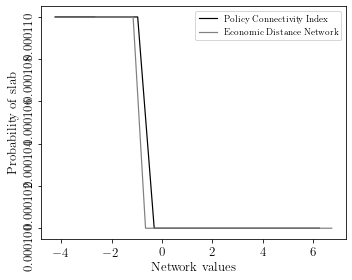

In [25]:
fig, ax = plt.subplots( figsize=(5,4))

nbins=10
MODIFIED_A_E_ints_10, MODIFIED_A_E_mids_10  = MODIFIED_get_density_els_marginal(A_tril=A_tril_E, 
                                                                  A_min=-2, A_max=6.5, 
                                                                  A_tril_pos=0, 
                                                                len_A_list=2, nbins=nbins,  eta_dict=etas_dict)

MODIFIED_A_P_ints_10, MODIFIED_A_P_mids_10 = MODIFIED_get_density_els_marginal(A_tril=A_tril_P, 
                                                                                   A_min=-2, A_max=6.5,
                                                                 A_tril_pos=1, 
                                                                len_A_list=2, nbins=nbins, eta_dict=etas_dict)


MODIFIED_df = pd.DataFrame.from_dict(MODIFIED_A_P_ints_10, orient='index')
MODIFIED_df = MODIFIED_df.astype('float64')
MODIFIED_df_P = MODIFIED_df.round(decimals = 5)

MODIFIED_df = pd.DataFrame.from_dict(MODIFIED_A_E_ints_10, orient='index')
MODIFIED_df = MODIFIED_df.astype('float64')
MODIFIED_df_E = MODIFIED_df.round(decimals = 5)

dfs = [MODIFIED_df_P, MODIFIED_df_E, ]
df_names = ['P', 'E', ]
ticklabs = [MODIFIED_A_P_mids_10, MODIFIED_A_E_mids_10 ]
legendlabs = ['Policy Connectivity Index', 'Economic Distance Network', ]
colors = ['black', 'gray']


for df_ix, df in enumerate(dfs):
    ax.plot(ticklabs[df_ix], df['w_slab'].values, linewidth=1.2, label=legendlabs[df_ix], color=colors[df_ix])

    ax.set_ylabel('Probability of slab')
    ax.set_xlabel('Network values')

plt.legend()
plt.yticks(rotation = 90)
plt.tight_layout()
plt.savefig('Stock_SS_prob_slab.pdf')

plt.show()

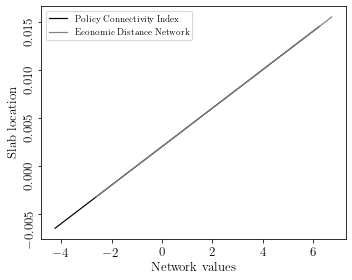

In [26]:
fig, ax = plt.subplots( figsize=(5,4))

MODIFIED_A_E_ints_10, MODIFIED_A_E_mids_10  = MODIFIED_get_density_els_marginal(A_tril=A_tril_E, 
                                                                  A_min=-2, A_max=6.5, 
                                                                  A_tril_pos=0, 
                                                                len_A_list=2, nbins=nbins,  eta_dict=etas_dict)

MODIFIED_A_P_ints_10, MODIFIED_A_P_mids_10 = MODIFIED_get_density_els_marginal(A_tril=A_tril_P, 
                                                                                   A_min=-2, A_max=6.5,
                                                                 A_tril_pos=1, 
                                                                len_A_list=2, nbins=nbins, eta_dict=etas_dict)


MODIFIED_df = pd.DataFrame.from_dict(MODIFIED_A_P_ints_10, orient='index')
MODIFIED_df = MODIFIED_df.astype('float64')
MODIFIED_df_P = MODIFIED_df.round(decimals = 5)

MODIFIED_df = pd.DataFrame.from_dict(MODIFIED_A_E_ints_10, orient='index')
MODIFIED_df = MODIFIED_df.astype('float64')
MODIFIED_df_E = MODIFIED_df.round(decimals = 5)

dfs = [MODIFIED_df_P, MODIFIED_df_E, ]
df_names = ['P', 'E', ]
ticklabs = [MODIFIED_A_P_mids_10, MODIFIED_A_E_mids_10 ]
legendlabs = ['Policy Connectivity Index', 'Economic Distance Network', ]
colors = ['black', 'gray']


for df_ix, df in enumerate(dfs):
    ax.plot(ticklabs[df_ix], df['mean_slab'].values, linewidth=1.2, label=legendlabs[df_ix], color=colors[df_ix])

    ax.set_ylabel('Slab location')
    ax.set_xlabel('Network values')

plt.legend()
plt.yticks(rotation = 90)
plt.tight_layout()
plt.savefig('Stock_SS_mean_slab.pdf')

plt.show()

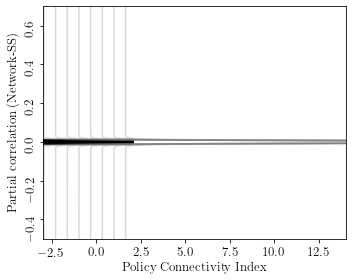

In [27]:
fig, ax = plt.subplots(figsize=(5,4))

with open(data_save_path +f'glasso_map.sav', 'rb') as fr:
    svi_glasso = pickle.load(fr)

with open(data_save_path +f'NetworkSS_E_P_2mcmc.sav', 'rb') as fr:
    mcmc2_ss_E_P = pickle.load(fr)
    
x_axis = jnp.arange(-1,1,0.001)
rho_tril_GLASSO = svi_glasso['rho_lt']
rho_tril = mcmc2_ss_E_P['all_samples']['rho_lt'].mean(0)

densities_E_P_P = []
for A_ix, (A_k, vals) in enumerate(A_P_ints_10.items()):
    density = jnp.exp(jnp.array([models.logprior_NetworkSS(scale_spike=vals['scale_spike'],
                                                           scale_slab=vals['scale_slab'],
                                                           w_slab=vals['w_slab'],
                                                           mean_slab=vals['mean_slab'],
                                                           rho_lt=x) for x in x_axis]))
    densities_E_P_P.append(density)
    ax.plot(density+A_P_mids_10[A_ix], x_axis, alpha=0.3, c='gray')
    
ax.scatter(A_tril_P, -rho_tril, s=18, linewidth=0.8, alpha=0.7, color='black', facecolors='none', label='partial correlations')
ax.set_xlim(-3,14)
ax.set_ylim(-0.5, 0.7)
ax.set_xlabel('Policy Connectivity Index')
ax.set_ylabel('Partial correlation (Network-SS)')

plt.yticks(rotation = 90) 
plt.tight_layout()
plt.savefig('Stock_SS_partial_corrs_P.pdf')

plt.show()

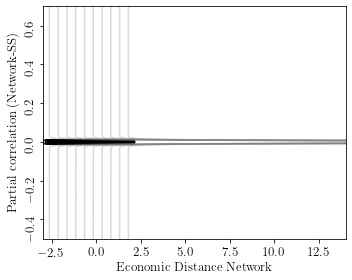

In [28]:
fig, ax = plt.subplots(figsize=(5,4))

with open(data_save_path +f'glasso_map.sav', 'rb') as fr:
    svi_glasso = pickle.load(fr)

with open(data_save_path +f'NetworkSS_E_P_2mcmc.sav', 'rb') as fr:
    mcmc2_ss_E_P = pickle.load(fr)
    
x_axis = jnp.arange(-1,1,0.001)
rho_tril_GLASSO = svi_glasso['rho_lt']
rho_tril = mcmc2_ss_E_P['all_samples']['rho_lt'].mean(0)

densities_E_P_E = []
for A_ix, (A_k, vals) in enumerate(A_E_ints_10.items()):
    density = jnp.exp(jnp.array([models.logprior_NetworkSS(scale_spike=vals['scale_spike'],
                                                           scale_slab=vals['scale_slab'],
                                                           w_slab=vals['w_slab'],
                                                           mean_slab=vals['mean_slab'],
                                                           rho_lt=x) for x in x_axis]))
    densities_E_P_E.append(density)
    ax.plot(density+A_E_mids_10[A_ix], x_axis, alpha=0.3, c='gray')
    
ax.scatter(A_tril_E, -rho_tril, s=18, linewidth=0.8, alpha=0.7, color='black', facecolors='none', label='partial correlations')
ax.set_xlim(-3,14)
ax.set_ylim(-0.5, 0.7)
ax.set_xlabel('Economic Distance Network')
ax.set_ylabel('Partial correlation (Network-SS)')

plt.yticks(rotation = 90)
plt.tight_layout()
plt.savefig('Stock_SS_partial_corrs_E.pdf')

plt.show()